# Identify Auditory Units

The content of this notebook is converted to a script at `scripts/calculate_auditory_units.py`

In this notebook we annotate units by some auditory properties (auditory in any 200ms window, auditory in first 500ms window, etc) as well as firing rate to songs, dcs, and ripples.

### 1 Creating unit summary dataframe

### 2 Venn diagram of auditory units

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

from soundsig.sound import spectrogram, plot_spectrogram

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from matplotlib_venn import venn3
from pandarallel import pandarallel

# Local imports
import groups
from analysis import (
    fit_kde,
    get_stimulus_timeseries,
    Auditory,
    ResponseStrength as RS,
)
from load_data import (
    load_auditory_info,
    load_spike_data,
    load_stim_data,
    load_ephys_stimulus, 
    load_unit_waveforms
)
from plotting import border, fig_grid, plot_raster
from stats import jackknife, false_discovery
from utils import Colors, clean_spike_times

%load_ext autoreload
%autoreload 2

In [2]:
pandarallel.initialize(progress_bar=True, use_memory_fs=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
ephys_data = load_spike_data()

In [4]:
stim_data = load_stim_data()

In [5]:
ephys_data.groupby("unit_id").describe()

electrode                                     \
                                    count mean  std  min  25%  50%  75%  max   
unit_id                                                                        
e0u0sGreBla5671F_200117_123306       58.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
e0u0sGreBla7410M_200116_163016       58.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
e0u10sGreBla5671F_200117_183229      58.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
e0u10sGreBla7410M_200116_185726      58.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
e0u10sRedBla0907M_191219_080025      58.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                   ...  ...  ...  ...  ...  ...  ...  ...   
e9u81sGreBla7410M_200116_102111      58.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0   
e9u84sGreBla7410M_200116_102111      58.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0   
e9u87sGreBla7410M_200116_102111      58.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0   
e9u88sGreBla7410M_200116_102111      58.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0   
e9u9sWhiRed9510F_191220_181416       58.0  9.0  0.0  9.0  9.0  9.0  9.0  9.0   

                                isi_violation_pct            ...  \
                                            count      mean  ...   
unit_id                                                      ...   
e0u0sGreBla5671F_200117_123306               58.0  0.002098  ...   
e0u0sGreBla7410M_200116_163016               58.0  0.000632  ...   
e0u10sGreBla5671F_200117_183229              58.0  0.000000  ...   
e0u10sGreBla7410M_200116_185726              58.0  0.000301  ...   
e0u10sRedBla0907M_191219_080025              58.0  0.047813  ...   
...                                           ...       ...  ...   
e9u81sGreBla7410M_200116_102111              58.0  0.000405  ...   
e9u84sGreBla7410M_200116_102111              58.0  0.000275  ...   
e9u87sGreBla7410M_200116_102111              58.0  0.000526  ...   
e9u88sGreBla7410M_200116_102111              58.0  0.084881  ...   
e9u9sWhiRed9510F_191220_181416               58.0  0.000000  ...   

                                stim_duration       unit                   \
                                          75%  max count  mean  std   min   
unit_id                                                                     
e0u0sGreBla5671F_200117_123306            6.0  6.0  58.0   0.0  0.0   0.0   
e0u0sGreBla7410M_200116_163016            6.0  6.0  58.0   0.0  0.0   0.0   
e0u10sGreBla5671F_200117_183229           6.0  6.0  58.0  10.0  0.0  10.0   
e0u10sGreBla7410M_200116_185726           6.0  6.0  58.0  10.0  0.0  10.0   
e0u10sRedBla0907M_191219_080025           6.0  6.0  58.0  10.0  0.0  10.0   
...                                       ...  ...   ...   ...  ...   ...   
e9u81sGreBla7410M_200116_102111           6.0  6.0  58.0  81.0  0.0  81.0   
e9u84sGreBla7410M_200116_102111           6.0  6.0  58.0  84.0  0.0  84.0   
e9u87sGreBla7410M_200116_102111           6.0  6.0  58.0  87.0  0.0  87.0   
e9u88sGreBla7410M_200116_102111           6.0  6.0  58.0  88.0  0.0  88.0   
e9u9sWhiRed9510F_191220_181416            6.0  6.0  58.0   9.0  0.0   9.0   

                                                         
                                  25%   50%   75%   max  
unit_id                                                  
e0u0sGreBla5671F_200117_123306    0.0   0.0   0.0   0.0  
e0u0sGreBla7410M_200116_163016    0.0   0.0   0.0   0.0  
e0u10sGreBla5671F_200117_183229  10.0  10.0  10.0  10.0  
e0u10sGreBla7410M_200116_185726  10.0  10.0  10.0  10.0  
e0u10sRedBla0907M_191219_080025  10.0  10.0  10.0  10.0  
...                               ...   ...   ...   ...  
e9u81sGreBla7410M_200116_102111  81.0  81.0  81.0  81.0  
e9u84sGreBla7410M_200116_102111  84.0  84.0  84.0  84.0  
e9u87sGreBla7410M_200116_102111  87.0  87.0  87.0  87.0  
e9u88sGreBla7410M_200116_102111  88.0  88.0  88.0  88.0  
e9u9sWhiRed9510F_191220_181416    9.0   9.0   9.0   9.0  

[2440 rows x 48 columns]

## Filter 1

SNR > 5

In [6]:
len(ephys_data.query("snr > 5").groupby("unit_id"))

1695

## Filter 2

isi_violation_pct < 0.001

In [7]:
len(ephys_data.query("isi_violation_pct < 0.001").groupby("unit_id"))

905

## Filter 3

This notebook is about identifying which units are auditory.

This is a little more complicated. I will use the measures of response strength laid out in the Response Strength Calcualtion notebook. First I will check if the unit is overall responsive to sounds. If not, I'll do a second check to see if any stims have a response that is significantly greater than zero (bonferroni corrected)

## 1 Create unit summary dataframe

The following cells create a dataframe with each unit annotated with auditory information. This is also produced by the script `scripts/calculate_auditory_units.py` and can just be loaded here.

In [8]:
unit_summary = load_auditory_info()

## Create tables for auditory columns

In [9]:
columns = {}

In [10]:
columns["auditory_in_any_1s"] = ephys_data.groupby("unit_id").parallel_apply(
    lambda unit_df: Auditory.is_auditory_by_any_rate(unit_df, alpha=0.01, delta_t=1.0),
)

In [11]:
columns["auditory_in_any_200ms"] = ephys_data.groupby("unit_id").parallel_apply(
    lambda unit_df: Auditory.is_auditory_by_any_rate(unit_df, alpha=0.01, delta_t=0.2)
)

In [12]:
columns["auditory_onset_500ms"] = ephys_data.groupby("unit_id").parallel_apply(
    lambda unit_df: Auditory.is_auditory_by_mean_rate(unit_df, alpha=0.05),
)

In [13]:
columns["fr"] = ephys_data.groupby("unit_id").apply(
    lambda unit_df: RS.rate(clean_spike_times(unit_df["spike_times"]))[0]
)

## Compare onset psths between renditions and noraml

In [14]:
rate_auditory_table = pd.DataFrame(
    columns,
    index=ephys_data.groupby("unit_id").grouper.levels[0]
).reset_index()

In [15]:
rate_auditory_table

,unit_id,auditory_in_any_1s,auditory_in_any_200ms,auditory_onset_500ms,fr
0,e0u0sGreBla5671F_200117_123306,False,True,False,4.465517
1,e0u0sGreBla7410M_200116_163016,False,False,False,1.962049
2,e0u10sGreBla5671F_200117_183229,False,True,False,0.433673
3,e0u10sGreBla7410M_200116_185726,True,True,False,2.389655
4,e0u10sRedBla0907M_191219_080025,True,True,True,3.686275
...,...,...,...,...,...
2435,e9u81sGreBla7410M_200116_102111,True,True,False,2.439716
2436,e9u84sGreBla7410M_200116_102111,True,True,True,3.931429
2437,e9u87sGreBla7410M_200116_102111,True,True,True,8.318841
2438,e9u88sGreBla7410M_200116_102111,False,False,False,NaN


## Join with the ephys data and re-aggregate by unit_id

Each group should have one unique value for the three columns "auditory_\*". So for each group just take a dummy value.

In [16]:
auditory_ephys_data = ephys_data.merge(rate_auditory_table, on="unit_id")

In [17]:
unit_summary = auditory_ephys_data.groupby("unit_id").agg({
    "subject": lambda x: x[0],
    "electrode": lambda x: x[0],
    "unit": lambda x: x[0],
    "site": lambda x: x[0],
    "snr": lambda x: x[0],
    "n_trials": "mean",
    "isi_violation_pct": lambda x: x[0],
    "fr": lambda x: x[0],
    "auditory_onset_500ms": lambda x: x[0],
    "auditory_in_any_200ms": lambda x: x[0],
    "auditory_in_any_1s": lambda x: x[0],
})

In [18]:
from load_data import load_rendition_data
rendition_data = load_rendition_data()

splits = [groups.all, groups.songs, groups.dcs, groups.ripples]
rate_data = []
for i in range(len(unit_summary)):
    row = unit_summary.iloc[i]
    _rendition_unit_data = rendition_data.query("unit_id == '{}'".format(row.name))
    result = {}
    for split in splits:
        fr,  _ = RS.rate(clean_spike_times(split(_rendition_unit_data)["spike_times"]), time_window=(0, 0.5))
        result["{}_fr".format(split.__name__)] = fr
    rate_data.append(result)
    
for split in splits:
    key = "{}_fr".format(split.__name__)
    unit_summary[key] = pd.Series([x[key] for x in rate_data], index=unit_summary.index)

## 2 Create Venn diagram of auditory units

#### Gather proportions for Venn diagram

In [19]:
def venn_counts(auditory_unit_summary, return_counts=True):
    results = {}
    for onset in [0, 1]:
        for any200ms in [0, 1]:
            for any1s in [0, 1]:
                section = (
                    (auditory_unit_summary["auditory_onset_500ms"] == onset)
                    & (auditory_unit_summary["auditory_in_any_200ms"] == any200ms)
                    & (auditory_unit_summary["auditory_in_any_1s"] == any1s)
                )
                if return_counts:
                    results["{}{}{}".format(onset, any200ms, any1s)] = section.sum()
                else:
                    results["{}{}{}".format(onset, any200ms, any1s)] = section.mean()
#                     {
#                         "frac": section.mean(),
#                         "count": section.sum()
#                     }
    for category in ["auditory_onset_500ms", "auditory_in_any_200ms", "auditory_in_any_1s"]:
        section = auditory_unit_summary[category] == True
        results[category] = {
            "frac": section.mean(),
            "count": section.sum()
        }
    return results

def _make_venn_dfs(auditory_unit_summary):
    results = {}
    for onset in [0, 1]:
        for any200ms in [0, 1]:
            for any1s in [0, 1]:
                section = (
                    (auditory_unit_summary["auditory_onset_500ms"] == onset)
                    & (auditory_unit_summary["auditory_in_any_200ms"] == any200ms)
                    & (auditory_unit_summary["auditory_in_any_1s"] == any1s)
                )
                results["{}{}{}".format(onset, any200ms, any1s)] = auditory_unit_summary[section]
    return results

In [20]:
venn_data = venn_counts(unit_summary, return_counts=True)

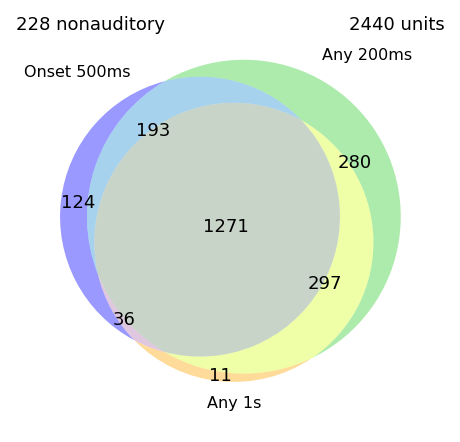

In [21]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
v = venn3(
    venn_data,
    set_labels=("Onset 500ms", "Any 200ms", "Any 1s"),
    set_colors=("Blue", "LimeGreen", "Orange"),
    normalize_to=0.3,
    ax=ax
)

for txt in v.set_labels:
    txt.set_fontsize(16)
for txt in v.subset_labels:
    txt.set_text("{:d}".format(int(txt.get_text())))
    txt.set_fontsize(18)

plt.text(
    0.02,
    0.98, 
    "{:d} nonauditory".format(venn_data["000"]), 
    fontsize=18, 
    horizontalalignment="left",
    verticalalignment="top", 
    transform=plt.gca().transAxes
)

plt.text(
    0.98,
    0.98, 
    "{:d} units".format(len(unit_summary)),
    fontsize=18, 
    horizontalalignment="right",
    verticalalignment="top", 
    transform=plt.gca().transAxes
)

fig.patch.set_facecolor("White")


## Create a table with auditory information for each unit

## Filter to n_trials > 8 (on average), isi_violation_pct < 0.001, and snr > 5

In [22]:
high_signal_units = unit_summary[
    (unit_summary["n_trials"] > 8) &
    (unit_summary["snr"] >= 5) &
    (unit_summary["isi_violation_pct"] < 0.001)
]

In [23]:
venn_data = venn_counts(high_signal_units, return_counts=True)

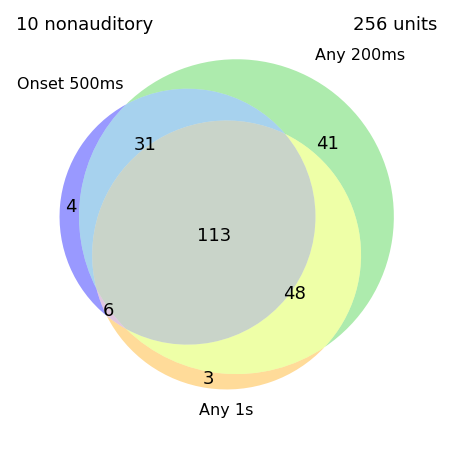

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = plt.gca()
v = venn3(
    venn_data,
    set_labels=("Onset 500ms", "Any 200ms", "Any 1s"),
    set_colors=("Blue", "LimeGreen", "Orange"),
    normalize_to=0.3,
    ax=ax
)

for txt in v.set_labels:
    txt.set_fontsize(16)
for txt in v.subset_labels:
    if txt is None: continue
    txt.set_text("{:d}".format(int(txt.get_text())))
    txt.set_fontsize(18)

plt.text(
    0.02,
    0.98, 
    "{:d} nonauditory".format(venn_data["000"]), 
    fontsize=18, 
    horizontalalignment="left",
    verticalalignment="top", 
    transform=plt.gca().transAxes
)

plt.text(
    0.98,
    0.98, 
    "{:d} units".format(len(high_signal_units)),
    fontsize=18, 
    horizontalalignment="right",
    verticalalignment="top", 
    transform=plt.gca().transAxes
)

fig.patch.set_facecolor("White")


## 